In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

# Compare master with a single version of our algorithm

## Read data

In [2]:
df_master = pd.read_csv('15-06-2022/master.csv')
df_master['branch'] = 'master'

df_new = pd.read_csv('15-06-2022/new-algorithm-60-us.csv')
df_new['branch'] = 'new-algorithm-d10us'

df = pd.concat([df_master, df_new], ignore_index = True)
df.sample(10)

,name,cpu_time_us,package_energy,core_energy,branch
228,QuickSort,477614,708434,83661,master
555,NBody parallel iterator,166977,538573,52662,new-algorithm-d10us
384,Life - parallel bridge generation,1406846076,1159204247,104640571,new-algorithm-d10us
123,Life - parallel iterators generation,16223904,14464318,1405335,master
285,NBody parallel iterator,644031,647704,77984,master
157,NBody sequential,42888,1844783,181305,master
595,NBody parallel iterator,397755,437377,42764,new-algorithm-d10us
427,NBody sequential,810119,3833730,431658,new-algorithm-d10us
300,MergeSort,63187510,129021947,15707148,new-algorithm-d10us
332,Life - sequential generation,1746848,8054789,1003206,new-algorithm-d10us


## Remove outliers

In [3]:
q_low = df["cpu_time_us"].quantile(0.01)
q_hi  = df["cpu_time_us"].quantile(0.99)
df = df[(df["cpu_time_us"] < q_hi) & (df["cpu_time_us"] > q_low)]

q_low = df["package_energy"].quantile(0.01)
q_hi  = df["package_energy"].quantile(0.99)
df = df[(df["package_energy"] < q_hi) & (df["package_energy"] > q_low)]

q_low = df["core_energy"].quantile(0.01)
q_hi  = df["core_energy"].quantile(0.99)
df = df[(df["core_energy"] < q_hi) & (df["core_energy"] > q_low)]

## Extract mean ratio

In [4]:
def extract_means(input_df):
    means = {'name': [],
             'branch': [],
             'cpu_time_us': [],
             'core_energy': [],
             'package_energy': []}

    for algorithm in set(input_df['name']):
        algorithm_df = input_df[input_df['name'] == algorithm]
        means['name'].append(algorithm)
        means['branch'].append(algorithm_df['branch'].values[0])
        means['cpu_time_us'].append(algorithm_df['cpu_time_us'].mean())
        means['core_energy'].append(algorithm_df['core_energy'].mean())
        means['package_energy'].append(algorithm_df['package_energy'].mean())
    
    return means


master_dict = extract_means(df_master)
new_algorithm_dict = extract_means(df_new)
means = {'name': [], 
         'cpu_time_ratio': [],
         'core_energy_ratio': [],
         'package_energy_ratio': []}

for index, algorithm in enumerate(master_dict['name']):
    means['name'].append(algorithm)
    means['cpu_time_ratio'].append(master_dict['cpu_time_us'][index] / new_algorithm_dict['cpu_time_us'][index])
    means['core_energy_ratio'].append(master_dict['core_energy'][index] / new_algorithm_dict['core_energy'][index])
    means['package_energy_ratio'].append(master_dict['package_energy'][index] / new_algorithm_dict['package_energy'][index])

df_to_plot = pd.DataFrame(data=means)
df_to_plot = df_to_plot.sort_values('cpu_time_ratio', ascending = False)
display(df_to_plot)


,name,cpu_time_ratio,core_energy_ratio,package_energy_ratio
4,NBody parallel reduce,3.071004,2.532946,2.458720
1,Life - parallel iterators generation,2.365678,2.051449,2.093855
0,NBody parallel iterator,2.245372,1.536495,1.551635
8,QuickSort,2.031924,0.961968,0.946721
7,Life - parallel bridge generation,0.961883,0.985653,0.996213
2,FrogJump,0.551365,0.851201,0.771186
5,Travelling Salesman Problem,0.548328,0.889653,0.847800
9,MergeSort,0.329854,0.772078,0.644471
3,NBody sequential,0.050445,0.517309,0.523547
6,Life - sequential generation,0.040115,0.461899,0.489487


## CPU time

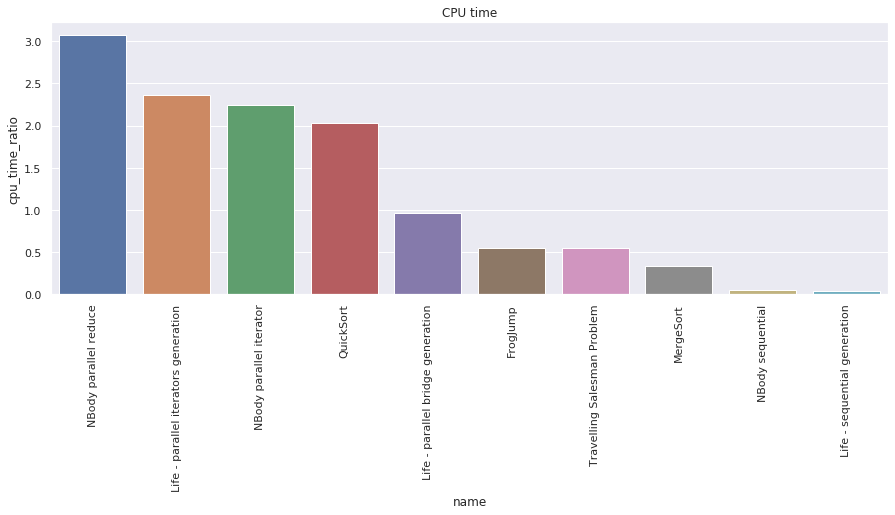

In [5]:
fig1, ax1 = plt.subplots(figsize=(15,5))
ax1.set_title('CPU time')
ax1.set_ylabel('Active time [us]')
ax1.set_xlabel('Algorithm')

sns.barplot(x='name', y='cpu_time_ratio', data=df_to_plot);
plt.xticks(rotation=90);

# x = mean(master) / mean(new_algorithm)
#     x < 1: we are losing
#     x > 1: we are winning

## Energy

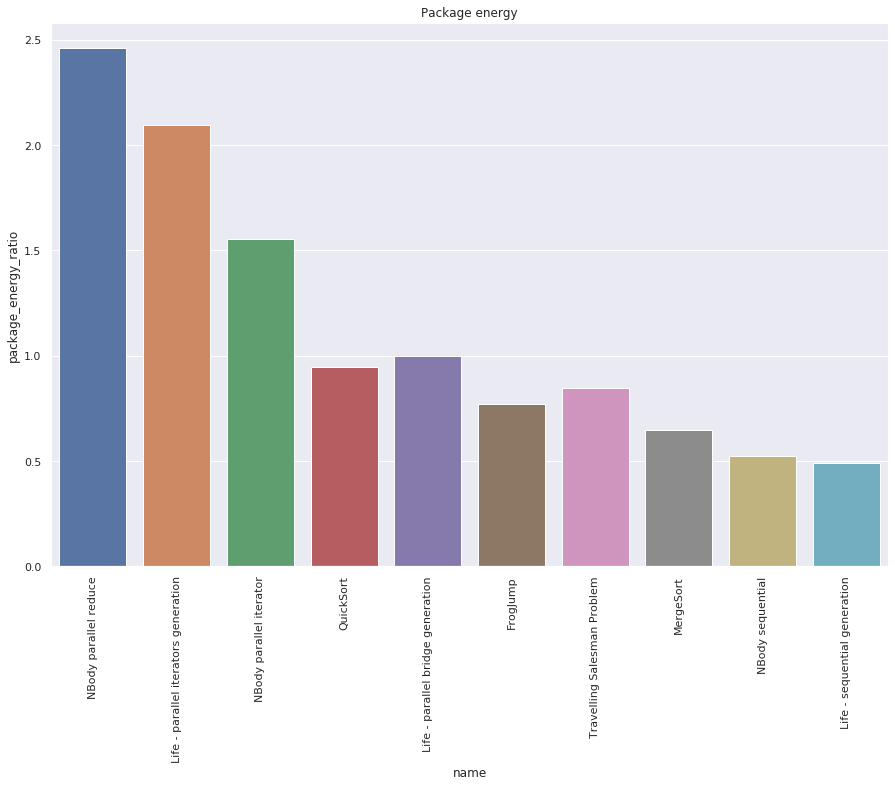

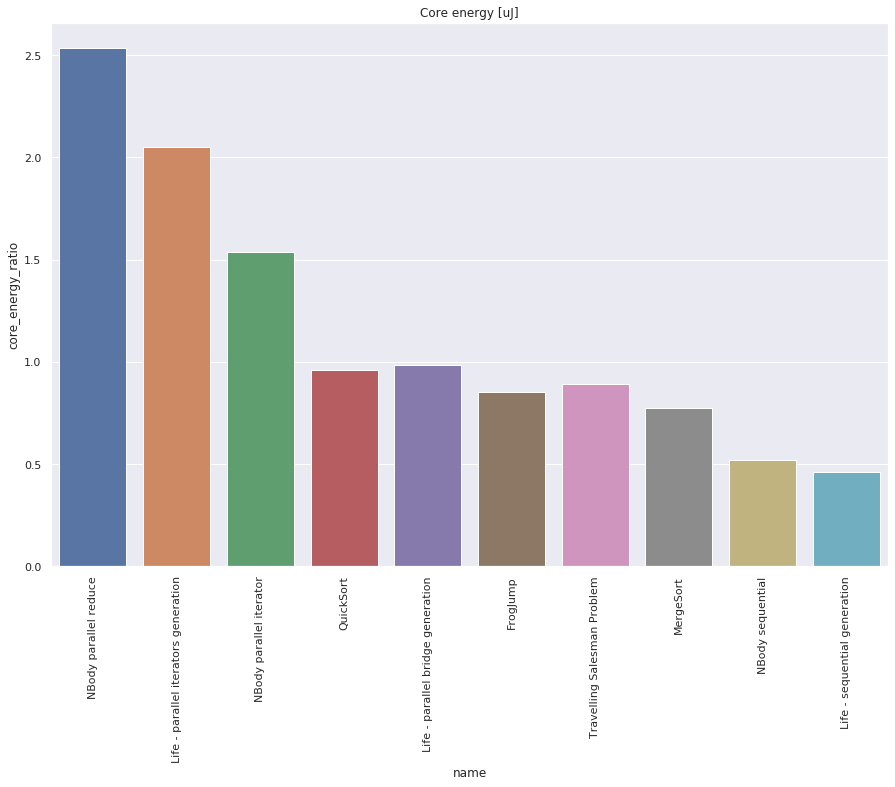

In [6]:
fig2, ax2 = plt.subplots(1, figsize=(15, 10));

ax2.set_title('Package energy')
ax2.set_ylabel('Energy [uJ]')
ax2.set_xlabel('Sleep duration [us]')
sns.barplot(x='name', y='package_energy_ratio', data=df_to_plot);
plt.xticks(rotation=90);

fig2, ax3 = plt.subplots(1, figsize=(15, 10));

ax3.set_title('Core energy [uJ]')
ax3.set_ylabel('Energy [uJ]')
ax3.set_xlabel('Sleep duration [us]')
sns.barplot(x='name', y='core_energy_ratio', data=df_to_plot);

plt.xticks(rotation=90);

## Histograms

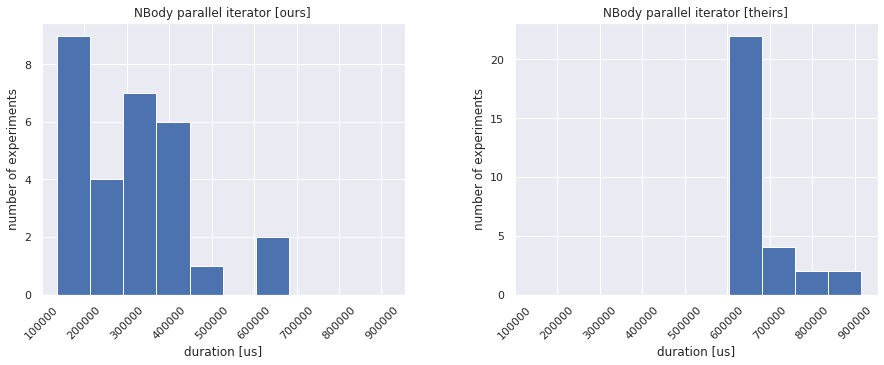

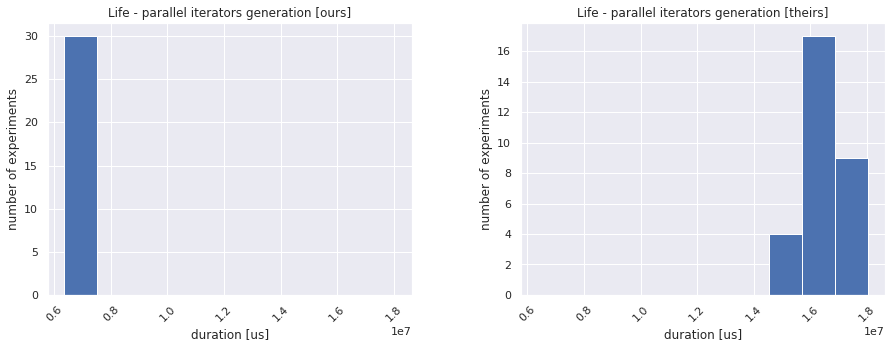

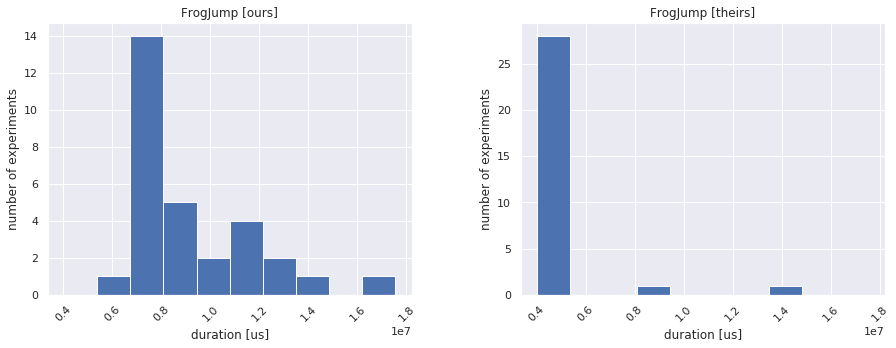

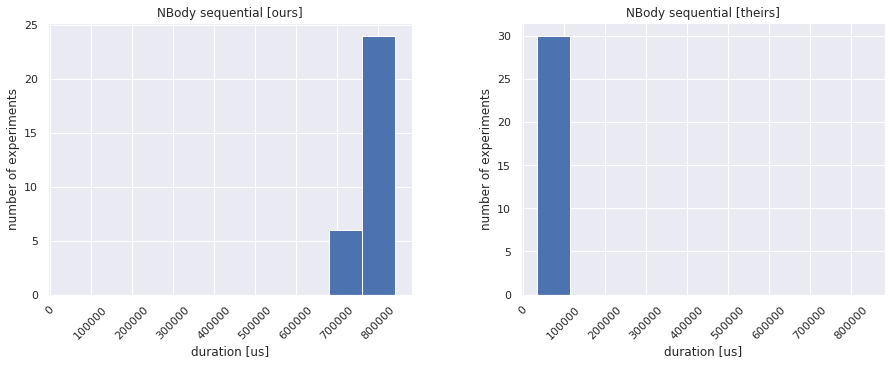

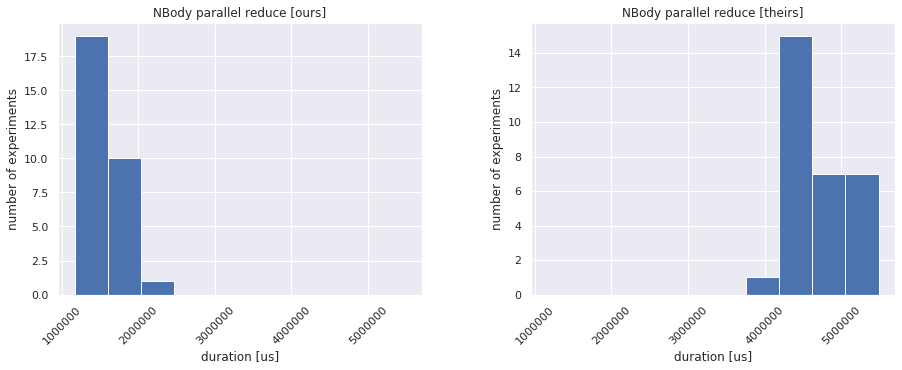

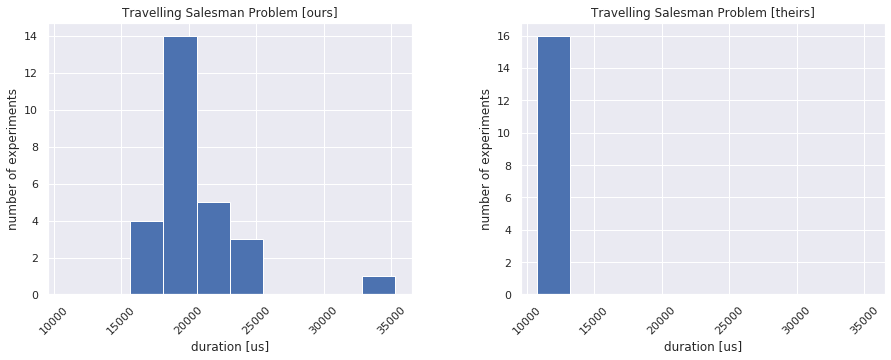

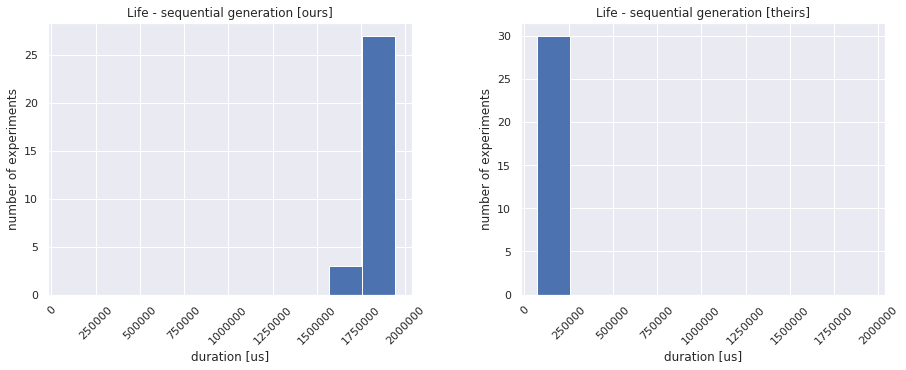

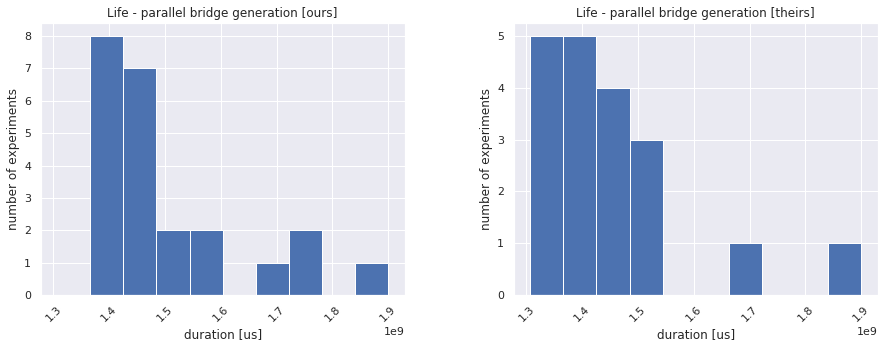

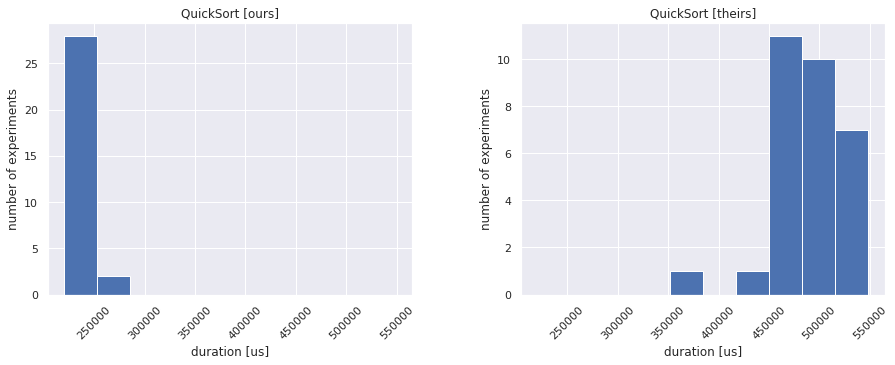

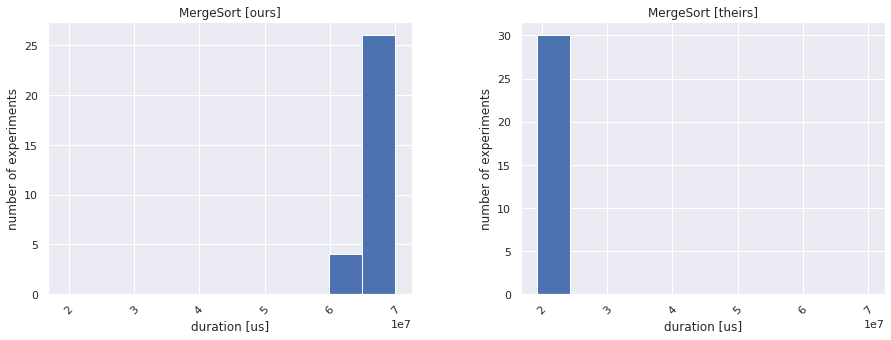

In [7]:
ours = df[df['branch'] != 'master']
theirs = df[df['branch'] == 'master']

for algorithm in set(df['name']):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    our_algorithm_df = ours[ours['name'] == algorithm]
    their_algorithm_df = theirs[theirs['name'] == algorithm]
    max_cpu_time = max(our_algorithm_df['cpu_time_us'].max(), their_algorithm_df['cpu_time_us'].max())
    min_cpu_time = min(our_algorithm_df['cpu_time_us'].min(), their_algorithm_df['cpu_time_us'].min())
    histogram_range = (min_cpu_time, max_cpu_time)

    our_hist = our_algorithm_df.hist(bins=10, column='cpu_time_us', ax=ax1, range=histogram_range)
    ax1.set_title(algorithm + ' [ours]')
    ax1.set_ylabel('number of experiments')
    ax1.set_xlabel('duration [us]')
    ax1.tick_params('x', labelrotation=45)


    their_hist = their_algorithm_df.hist(bins=10, column='cpu_time_us', ax=ax2, range=histogram_range)
    ax2.set_title(algorithm + ' [theirs]')
    ax2.set_ylabel('number of experiments')
    ax2.set_xlabel('duration [us]')
    ax2.tick_params('x', labelrotation=45) 
    

# Compare all implementations

## Read data

In [8]:
master_df = pd.read_csv('15-06-2022/master.csv')
master_df['branch'] = 'master'

for i in [1, 2, 4, 6, 8, 10, 20, 30, 40, 50, 60]:
    filename = '15-06-2022/new-algorithm-' + str(i) + '-us.csv'
    our_df = pd.read_csv(filename)
    our_df['branch'] = str(i) + 'us'
    master_df = pd.concat([master_df, our_df], ignore_index = True)

## Plot data

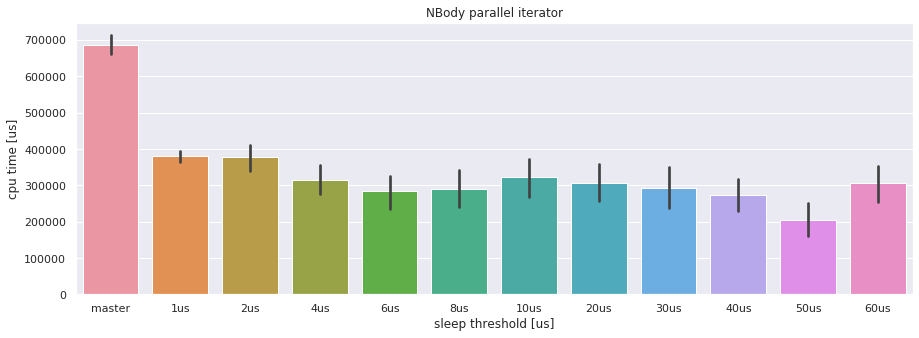

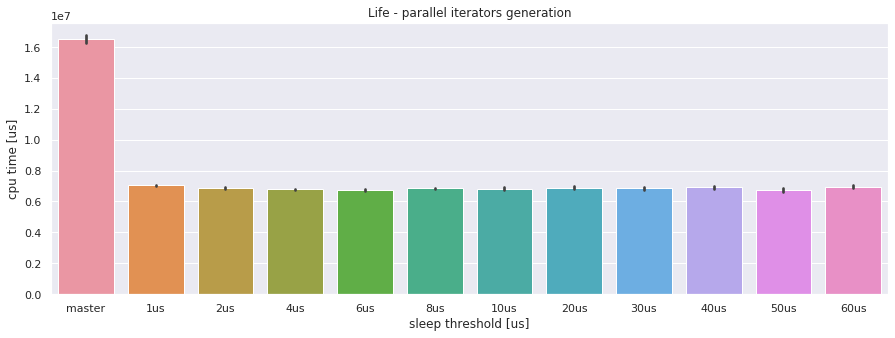

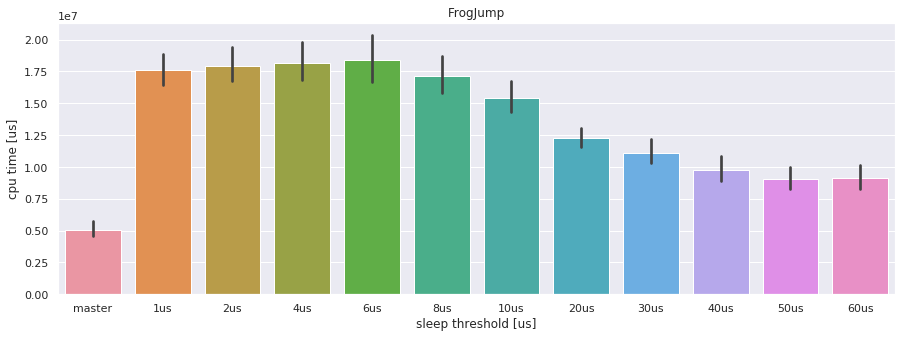

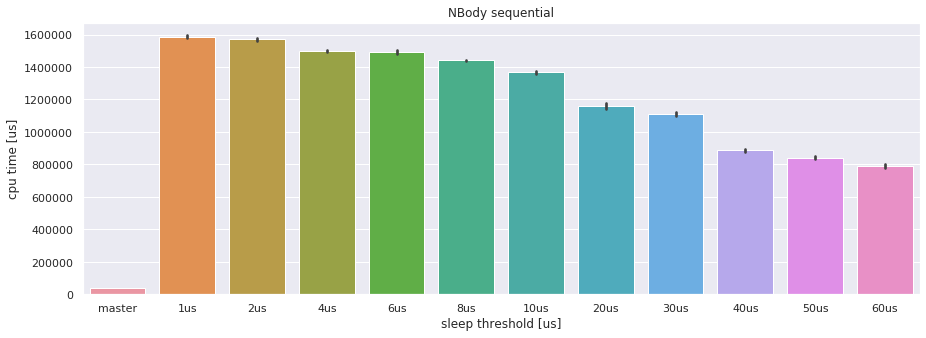

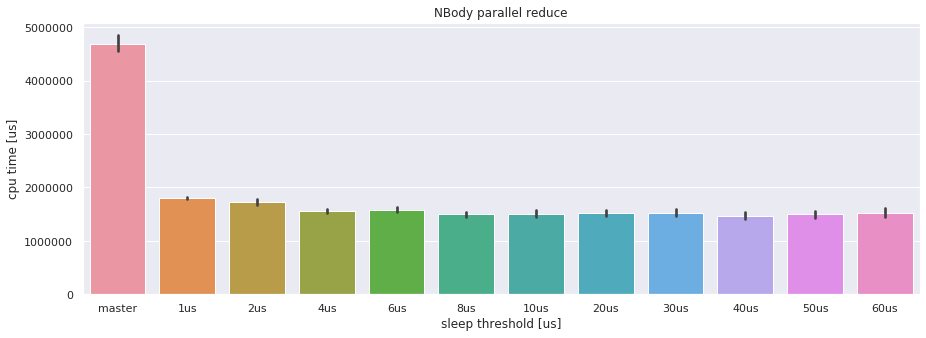

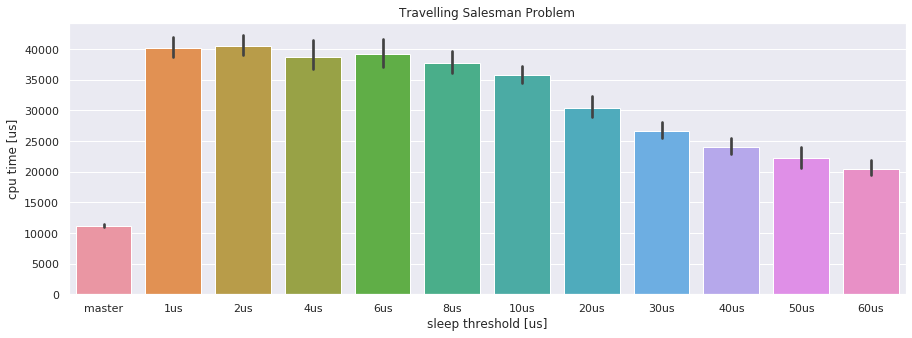

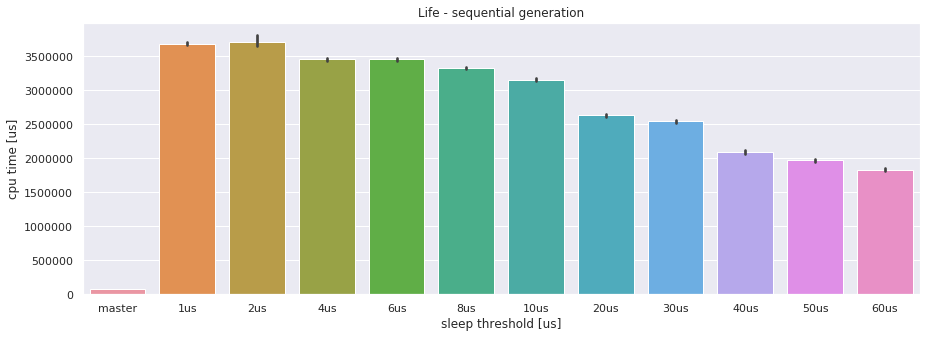

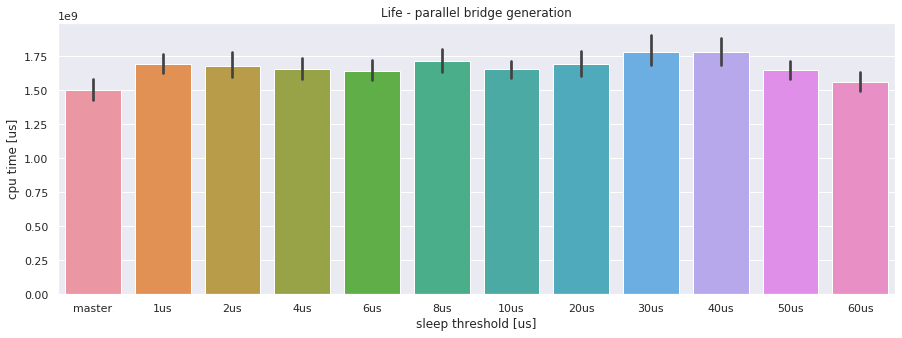

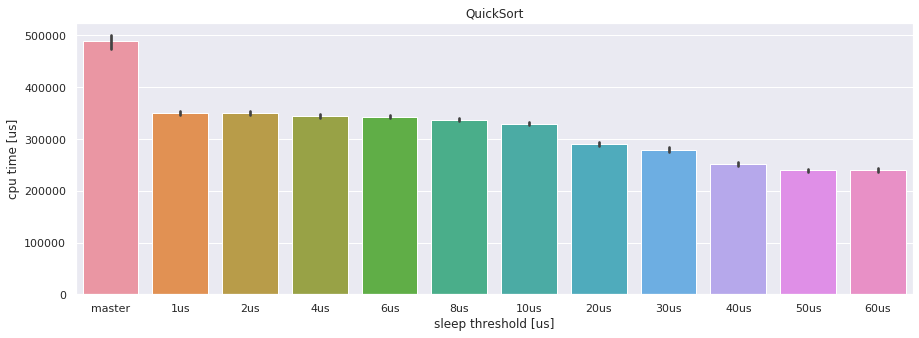

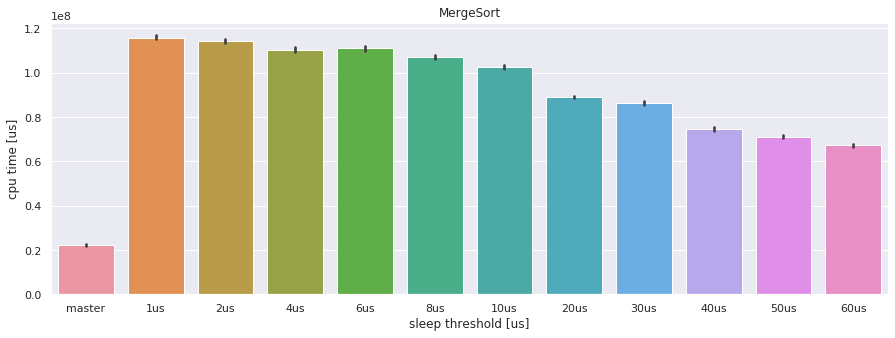

In [9]:
for algorithm in set(master_df['name']):
    df_to_plot = master_df[master_df['name'] == algorithm]
    
    fig, ax = plt.subplots(figsize=(15, 5))
    sns.barplot(x='branch', y='cpu_time_us', data=df_to_plot, ax=ax);
    ax.set_title(algorithm)
    ax.set_xlabel('sleep threshold [us]')
    ax.set_ylabel('cpu time [us]')
    